# Test reading zipped MSG files and randomly sampling patches

In [3]:
import pathlib
import tempfile
import os
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta

from satpy import Scene

In [4]:
seviri_path = pathlib.Path("/gws/nopw/j04/eo_shared_data_vol2/satellite/seviri/FDS/")

In [11]:
(seviri_path/"2010"/"07"/"01").exists()

True

In [5]:
seviri_files = sorted(list((seviri_path/"2010"/"07"/"01").glob("MSG*-NA.zip")))

In [13]:
zf = zipfile.ZipFile(seviri_files[48])

with tempfile.TemporaryDirectory() as tempdir:
    zf.extractall(tempdir)
    print(tempdir)
    seviri_file = list(pathlib.Path(tempdir).glob("MSG*-NA.nat"))[0]
    print(seviri_file)
    scn = Scene([seviri_file], reader="seviri_l1b_native")
    scn.load([
        'IR_016',
        'IR_039',
        'IR_087',
        'IR_097',
        'IR_108',
        'IR_120',
        'IR_134',
        'VIS006',
        'VIS008',
        'WV_062',
        'WV_073'
    ])
    msg_ds = scn.to_xarray().load()

/tmp/tmp6fwonq6r
/tmp/tmp6fwonq6r/MSG2-SEVI-MSG15-0100-NA-20100701121241.868000000Z-NA.nat


In [ ]:
def read_zipped_msg(filename, channels=None):
    if channels is None:
        channels = [
            'IR_016',
            'IR_039',
            'IR_087',
            'IR_097',
            'IR_108',
            'IR_120',
            'IR_134',
            'VIS006',
            'VIS008',
            'WV_062',
            'WV_073'
        ]
    
    zf = zipfile.ZipFile(filename)

    with tempfile.TemporaryDirectory() as tempdir:
        zf.extractall(tempdir)
        seviri_file = list(pathlib.Path(tempdir).glob("MSG*-NA.nat"))[0]
        scn = Scene([seviri_file], reader="seviri_l1b_native")
        scn.load(channels)
        msg_ds = scn.to_xarray().load()

    return msg_ds

In [ ]:
msg_ds = read_zipped_msg(seviri_files[1], channels=[
            'IR_016',
            'IR_039',
            'IR_087',
            'IR_097',
            'IR_108',
            'IR_120',
            'IR_134',
            'VIS006',
            'VIS008',
            'WV_062',
            'WV_073'
])

In [ ]:
msg_ds.VIS006.plot()

### Randomly sample 50000 files from the MSG archive

In [ ]:
def random_date(start, end):
    """
    Generate a random datetime between two datetime objects.
    """
    delta = end - start
    random_days = np.random.randint(0, delta.days + 1)
    return start + timedelta(days=random_days)

def random_time(start, end):
    """
    Generate a random time between two time objects.
    """
    start_minutes = (start.hour * 60) + (start.minute)
    end_minutes = (end.hour * 60) + (end.minute)
    random_minutes = np.random.randint(start_minutes, end_minutes + 1)
    return datetime(2000, 1, 1, random_minutes // 60, random_minutes % 60, 0)

def random_datetime(start, end):
    """
    Generate a random datetime between two datetime objects.
    """
    random_date_value = random_date(start, end)
    random_time_value = random_time(datetime(2000, 1, 1, 0, 0, 0), datetime(2000, 1, 1, 23, 59, 00))
    return datetime(random_date_value.year, random_date_value.month, random_date_value.day,
                    random_time_value.hour, random_time_value.minute, random_time_value.second)

In [ ]:
dt = random_datetime(datetime(2010, 1, 1), datetime(2010, 12, 31))

In [ ]:
FILEPATH = '/gws/nopw/j04/eo_shared_data_vol2/satellite/seviri/FDS'

In [ ]:
def sample_msg_files(start, end, num_files=10):
    """
    Sample random MSG files from within the specified date range.
    Compile a dataframe with the samples filenames.
    Args:
        start (datetime): Start date for sampling.
        end (datetime): End date for sampling.
        num_files (int): Number of files to sample.
    """

    sampled_files = []

    # add progress bar
    pbar = tqdm(total=num_files, desc="Sampling MSG files", unit="file")
    pbar.set_postfix(start=start, end=end)
    pbar.update(0)
    while len(sampled_files) < num_files:
        try:
            dt = random_datetime(start, end)
            year = dt.year
            month = dt.month
            day = dt.day
            hour = dt.hour

            # list all files available for this date and hour
            seviri_files = os.listdir(f'{FILEPATH}/{year}/{month:02d}/{day:02d}/')

            hour_files = [f for f in seviri_files if f'NA-{year}{month:02d}{day:02d}{hour:02d}' in f]
            
            if not hour_files:
                continue  # Skip if no files found for this datetime
            
            sampled_file = np.random.choice(hour_files)
            sampled_files.append({
                'filename': str(sampled_file),
                'path': f'{FILEPATH}/{year}/{month:02d}/{day:02d}/{sampled_file}',
                'datetime': dt,
            })
            pbar.update(1)
            
        except Exception as e:
            continue
    
    # turn the list of sampled files into a DataFrame
    df = pd.DataFrame(sampled_files)
    df['datetime'] = pd.to_datetime(df['datetime'])
    pbar.close()
    return df

In [ ]:
df = sample_msg_files(datetime(2004, 1, 19), datetime(2025, 2, 28), num_files=50000)

In [ ]:
df.to_csv('msg-sample-50000.csv', index=False)

In [6]:
df = pd.read_csv('msg-sample-50000.csv')

In [7]:
import sys
import pathlib
sys.path.append(str(pathlib.Path().resolve().parent))

from scripts.process_utils import CenterWeightedCropDatasetEditor, read_zipped_msg

def load_and_patch_msg(file_path, patch_size, fov_radius):
    """
    Load and patch MSG file using Satpy.
    
    Args:
        file_path (str): Path to the MSG file.
        patch_size (int): Size of the patch to crop from the dataset.
        fov_radius (float): Field of view radius for cropping.
    
    Returns:
        xarray.Dataset: Patched dataset.
    """
    ds = read_zipped_msg(file_path)

    # Crop dataset into patch
    crop = CenterWeightedCropDatasetEditor(
        patch_shape=(patch_size, patch_size), 
        fov_radius=fov_radius,
        satellite = 'msg')
    
    result = crop(ds)

    if result is None: # i.e. if no valid patch was found
        print(f"Could not find valid patch ...")
        return None

    return result

In [8]:
num = np.random.randint(0, len(df))
test_path = df['path'].iloc[num]
test_patch, xmin, ymin = load_and_patch_msg(test_path, patch_size=1024, fov_radius=0.6)

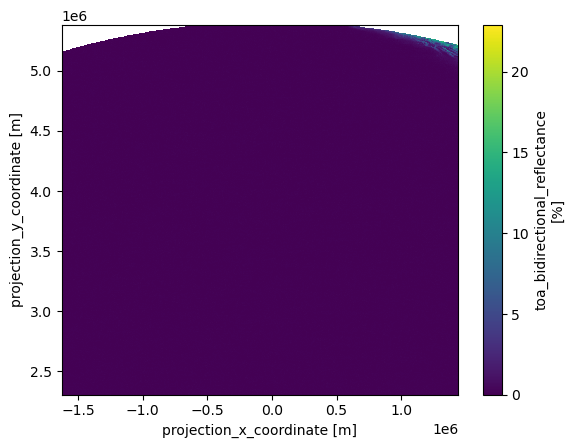

In [9]:
test_patch.IR_016.plot()